In [33]:
import os

import numpy as np
import pandas as pd

# import warnings
# warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn
from sklearn import metrics
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from venn import venn

In [2]:
PATH = "/app/_data/"
BATCH_SIZE = 64
SEED = 42
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 6
INPUT_SIZE = (224, 224, 3)

In [3]:
labels = pd.read_csv(PATH+'train_labels.csv',index_col=[0])
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [4]:
sample_submission

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [5]:
labels.head()
labels.info()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18532 non-null  object
 1   labels  18532 non-null  object
dtypes: object(2)
memory usage: 434.3+ KB


In [6]:
labels["labels"].value_counts(normalize=True)

scab                               0.260091
healthy                            0.249514
frog_eye_leaf_spot                 0.171541
rust                               0.096967
complex                            0.085258
powdery_mildew                     0.063889
scab frog_eye_leaf_spot            0.037017
scab frog_eye_leaf_spot complex    0.010792
frog_eye_leaf_spot complex         0.008904
rust frog_eye_leaf_spot            0.006421
rust complex                       0.004910
powdery_mildew complex             0.004695
Name: labels, dtype: float64

In [7]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [8]:
feature_columns = labels.columns[2:].tolist()
labels[feature_columns]
# = labels[feature_columns].astype('float')

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
...,...,...,...,...,...,...
18627,0,0,1,0,0,0
18628,0,0,0,0,0,1
18629,0,0,0,0,1,0
18630,0,1,0,0,0,1


## resizing and saving images

In [58]:
def resize_im(
    image_name, new_folder_name="666_bicubic", size=(666, 666), resample=Image.BICUBIC
):
    image = Image.open(PATH + "train_images/" + image_name)
    image = image.resize(size, resample=resample)
    if not os.path.isdir(PATH + "train_images/" + new_folder_name + "/"):
        os.mkdir(PATH + "train_images/" + new_folder_name + "/")
    image.save(PATH + "train_images/" + new_folder_name + "/" + image_name)
labels['image'].apply(resize_im)

0        None
1        None
2        None
3        None
4        None
         ... 
18627    None
18628    None
18629    None
18630    None
18631    None
Name: image, Length: 18532, dtype: object

## weights

In [10]:
# labels["multi_label"] = labels["labels"].astype("category").cat.codes
# dict_weights = (
#     1
#     / labels["multi_label"].value_counts()
#     / np.sum(1 / labels["multi_label"].value_counts())
# ).to_dict()
# def weight_fill(x):
#    return dict_weights[x]
# labels['weights'] = labels["multi_label"].apply(weight_fill)

## ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    brightness_range=(0.5, 1.5),
    shear_range=45,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
)
train = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_bicubic/",
#     directory=PATH + "train_images/",

    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED,
    interpolation = 'bicubic'
)

Found 14826 validated image filenames.


In [12]:
valid_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
)
valid = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_bicubic/",
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED,
    interpolation = 'bicubic'
)

Found 3706 validated image filenames.


In [38]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED,
    shuffle=False,
    interpolation = 'bicubic'
)

Found 3 validated image filenames.


### plots

In [14]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

## model

### base_model

In [15]:
# backbone = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
# model_w = Sequential()
# model_w.add(backbone)
# model_w.add(GlobalAveragePooling2D())
# model_w.add(Dense(units=7, activation="sigmoid"))
# model_w.compile(
#     loss="CategoricalCrossentropy",
#     optimizer=Adam(lr=0.001),
#     metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), tfa.metrics.F1Score(
#                     num_classes=7,
#                     average='macro')]
# )

### from keras
<https://keras.io/guides/preprocessing_layers/#image-preprocessing-layers>

In [16]:
data_augmentation = keras.Sequential(
    [
#         keras.layers.experimental.preprocessing.Normalization(),
#         keras.layers.experimental.preprocessing.Resizing(224,224),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomHeight(0.1),
        keras.layers.experimental.preprocessing.RandomWidth(0.1),
        keras.layers.experimental.preprocessing.RandomRotation(0.15),
        keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
        
    ]
)
#         keras.preprocessing.image.random_shear(45),
#         keras.preprocessing.image.random_rotation(45),
#         keras.preprocessing.image.random_brightness(0.5, 1.5),
#         keras.preprocessing.image.random_zoom(0.75, 1.25),
#         keras.preprocessing.image.random_shift(0.25, 0.25)
# x = keras.preprocessing.image.random_shear(x, 45, row_axis=0, col_axis=1, channel_axis=2),
# x = keras.preprocessing.image.random_rotation(x, 45, row_axis=0, col_axis=1, channel_axis=2),
# x = keras.preprocessing.image.random_brightness(x, (0.5, 1.5)),
# x = keras.preprocessing.image.random_zoom(x, (0.75, 1.25), row_axis=0, col_axis=1, channel_axis=2),
# x = keras.preprocessing.image.random_shift(x, 0.25, 0.25, row_axis=0, col_axis=1, channel_axis=2)

In [17]:
# def preprocess_data(x, y):
#     x_p = data_augmentation(x)
#     x_p = keras.applications.resnet.preprocess_input(x_p)
#     return (x_p, y)

In [18]:
# preprocess_data(next(valid)[0])

### func style

In [19]:
inputs = keras.Input(shape=INPUT_SIZE)
# x = data_augmentation(inputs)
# x = keras.applications.resnet.preprocess_input(inputs)
x = keras.applications.ResNet50(weights="imagenet", include_top=False)(inputs)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif 5 <= epoch:
        return 0.0005
#     else:
#         return 0.0001

In [21]:
callbacks=[
        keras.callbacks.EarlyStopping(monitor='loss',
            patience=5, restore_best_weights=True, verbose=1),
#         keras.callbacks.LearningRateScheduler(schedule = scheduler, verbose=1)
        ]

In [22]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=['acc',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
    ],
)

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [24]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)

Epoch 1/20
232/232 [==============================] - 258s 1s/step - loss: 0.2293 - acc: 0.7380 - recall: 0.6685 - precision: 0.7857 - f1_score: 0.7359 - val_loss: 0.4768 - val_acc: 0.2979 - val_recall: 0.3140 - val_precision: 0.3338 - val_f1_score: 0.3236
Epoch 2/20
232/232 [==============================] - 266s 1s/step - loss: 0.1719 - acc: 0.8122 - recall: 0.7639 - precision: 0.8467 - f1_score: 0.8054 - val_loss: 0.4707 - val_acc: 0.2717 - val_recall: 0.0010 - val_precision: 0.1379 - val_f1_score: 0.2961
Epoch 3/20
232/232 [==============================] - 264s 1s/step - loss: 0.1572 - acc: 0.8289 - recall: 0.7852 - precision: 0.8593 - f1_score: 0.8206 - val_loss: 0.5212 - val_acc: 0.1711 - val_recall: 0.0340 - val_precision: 0.1468 - val_f1_score: 0.1810
Epoch 4/20
232/232 [==============================] - 264s 1s/step - loss: 0.1486 - acc: 0.8388 - recall: 0.7985 - precision: 0.8655 - f1_score: 0.8293 - val_loss: 0.6859 - val_acc: 0.3003 - val_recall: 0.2681 - val_precision: 0.

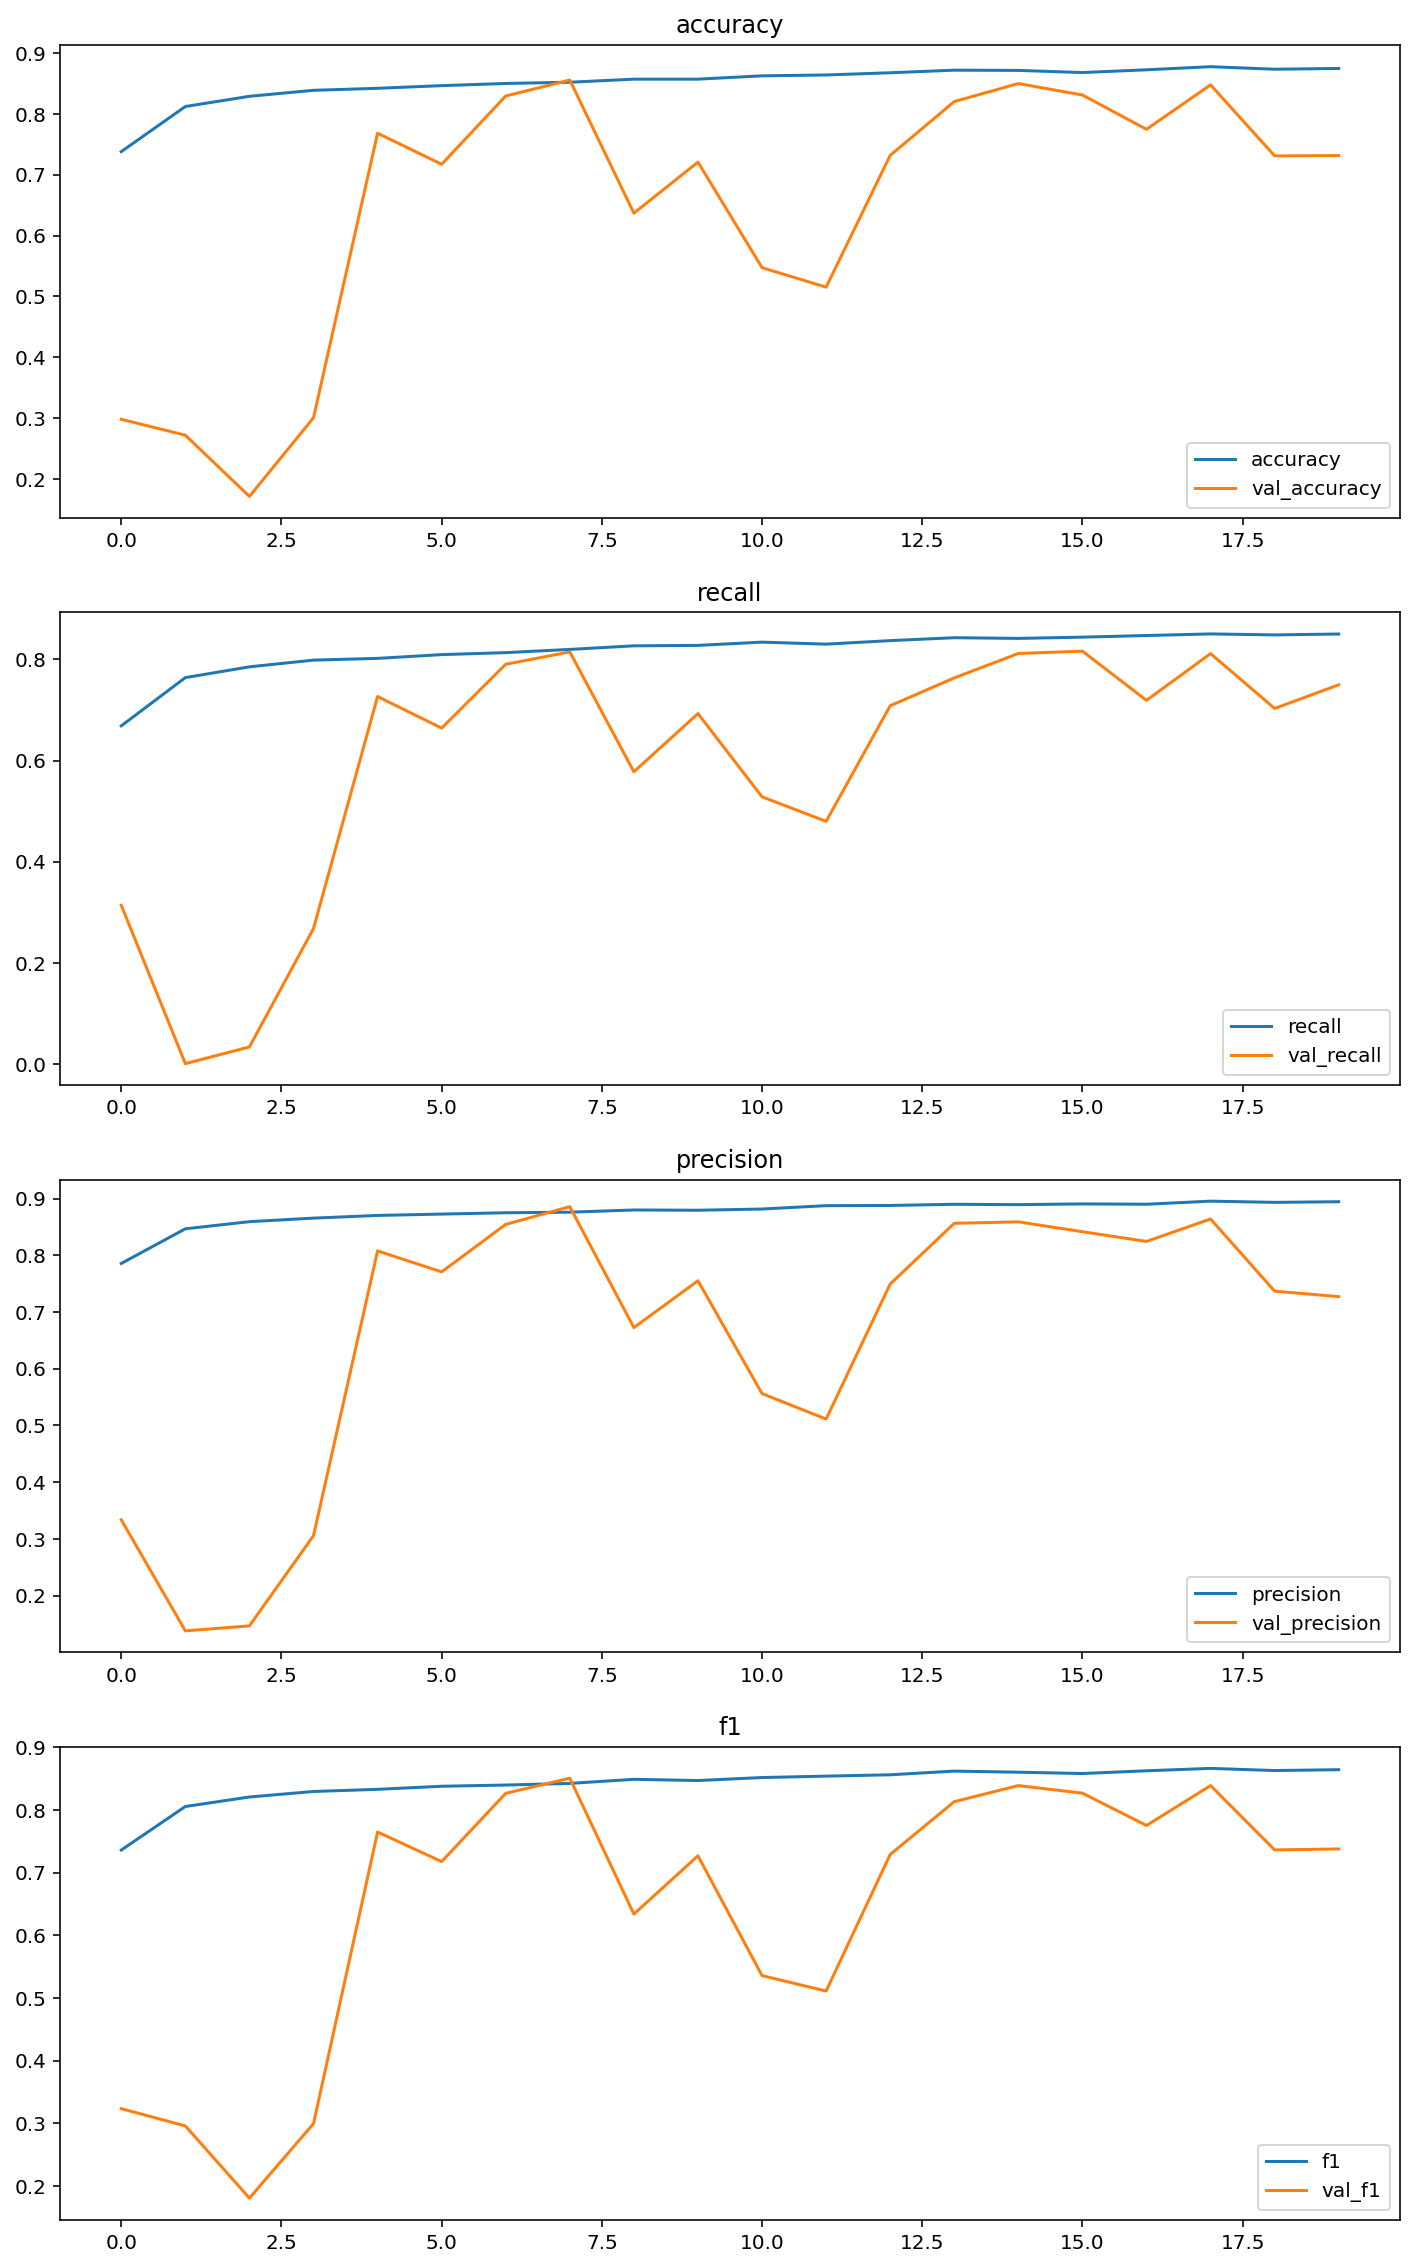

In [25]:
plot_curves(history)

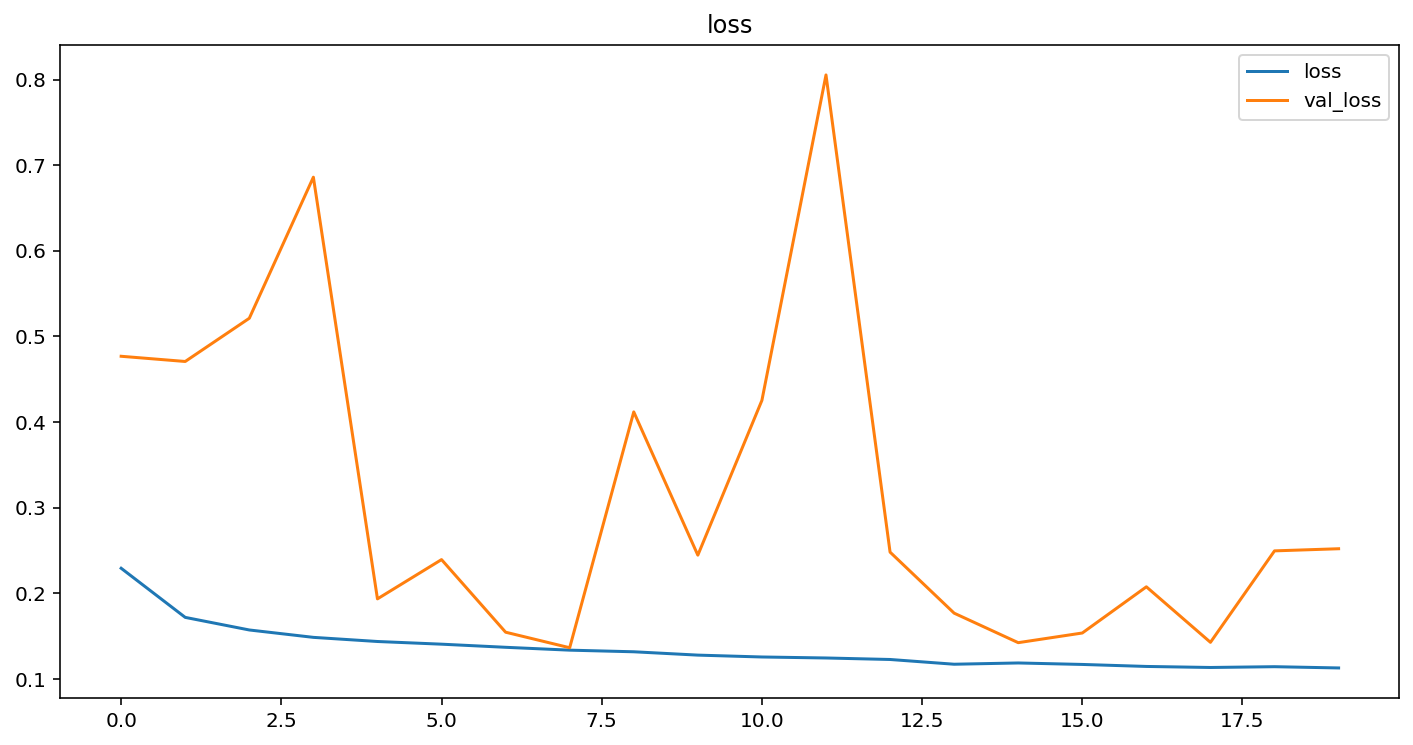

In [26]:
plot_curves(history, loss=True)

In [ ]:
IMG_PATH = '/app/_data/train_images/small_bicubic/'

In [41]:
def get_prediction(predict_train =False, predict_valid=False, all_img = False):
    if all_img:
        all_img = ImageDataGenerator(rescale=1.0 / 255).flow_from_dataframe(
        dataframe=labels,
        directory=IMG_PATH,
        x_col="image",
        y_col=feature_columns,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="raw",
        seed=SEED,
        interpolation = 'bicubic',
        shuffle=False,
    )
        prediction_all = model.predict(all_img)
        prediction = pd.DataFrame(prediction_all, columns=feature_columns).join(pd.DataFrame(all_img._targets, columns=feature_columns), rsuffix='_true', lsuffix = '_pred')
        prediction.index = all_img.filenames
    elif predict_valid:       
        prediction_valid = model.predict(valid)
        prediction = pd.DataFrame(prediction_valid, columns=feature_columns).join(pd.DataFrame(valid._targets, columns=feature_columns), rsuffix='_true', lsuffix = '_pred')
        prediction.index = valid.filenames
    elif predict_train:
        train = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=IMG_PATH,
            x_col="image",
            y_col=feature_columns,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode="raw",
            subset="training",
            seed=SEED,
            interpolation = 'bicubic',
            shuffle=False
        )
        prediction_train = model.predict(train)
        prediction = pd.DataFrame(prediction_train, columns=feature_columns).join(pd.DataFrame(train._targets, columns=feature_columns), rsuffix='_true', lsuffix = '_pred')
        prediction.index = train.filenames
    return prediction

In [42]:
pred_all = get_prediction(all_img=True)
# pred_all.to_csv('/app/sandbox/wrong_predictions/prediction_raw_1.csv')

Found 18532 validated image filenames.


## test

In [ ]:
prediction = model.predict(test) > 0.5

In [ ]:
test_sub = pd.DataFrame(prediction, columns=feature_columns)
for name in test_sub.columns.tolist():
    test_sub[name] = test_sub[name].replace({True: name, False: ""})
test_sub["all"] = test_sub.apply(" ".join, axis=1).str.split().str.join(sep=" ")
test_sub.to_csv("app/sandbox/test_sub.csv")

In [ ]:
backbone = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=6, activation="sigmoid"))
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=6, average="micro"),
    ],
)

In [ ]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=3,
    batch_size=BATCH_SIZE,
    #     steps_per_epoch=64,
    #     validation_steps=16,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
model_l = keras.models.load_model('/app/_data/models/base_model')

In [ ]:
a = model_l.predict(valid)

In [ ]:
a[0]